In [1]:
from pathlib import Path
import xarray as xr

import sys

sys.path.append(str(Path("../src").resolve()))

import torch
import torch.nn.functional
from torch.utils.data import DataLoader
from st_encoder_decoder import SpatioTemporalModel
from utils import pred_to_numpy
from dataset import STDataset

## Read data

In [2]:
# data_folder = Path("../../data/output/")
data_folder = Path("~/temp/eso4clima/")

file_names = [data_folder / "202001_day_ERA5_masked_ts.nc", data_folder / "202002_day_ERA5_masked_ts.nc"]
daily_data = xr.open_mfdataset(file_names)

file_names = [data_folder / "202001_mon_ERA5_full_ts.nc", data_folder / "202002_mon_ERA5_full_ts.nc"]
monthly_data = xr.open_mfdataset(file_names)

file_name = data_folder / "era5_lsm_bool.nc"  # downloded from era5 and regridded using the function `regrid_to_boundary_centered_grid`
lsm_mask = xr.open_dataset(file_name)
lsm_mask = lsm_mask.rename({'latitude': 'lat', 'longitude': 'lon'})

## Subset data (for fast example)

In [3]:
# coordinates of subset
lon_subset = slice(-50, 50)
lat_subset = slice(-20, 20)

daily_subset = daily_data.sel(lon=lon_subset, lat=lat_subset)
monthly_subset = monthly_data.sel(lon=lon_subset, lat=lat_subset)
lsm_subset = lsm_mask.sel(lon=lon_subset, lat=lat_subset)

In [4]:
daily_subset["ts"].shape

(60, 160, 400)

## Create the model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpatioTemporalModel(embed_dim=128, patch_size=(1, 16, 16), overlap=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
decoder = model.decoder

with torch.no_grad():
    decoder.bias.fill_(monthly_subset["ts"].values.mean())
    decoder.scale.fill_(
        monthly_subset["ts"].values.std() + 1e-6
    )  # small epsilon to avoid zero

print(f'mean: {monthly_subset["ts"].values.mean()}, std: {monthly_subset["ts"].values.std()}')

mean: 299.22332763671875, std: 3.12893009185791


In [13]:
dataset = STDataset(
    daily_da=daily_subset["ts"],
    monthly_da=monthly_subset["ts"],
    land_mask=lsm_subset["lsm"],
    patch_size=(80, 160),
    overlap=0,
)

In [18]:
# test data shapes 
dataloader_test = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    pin_memory=False,
)

first_batch = next(iter(dataloader_test))
daily_batch = first_batch["daily_patch"]  # (B, C, M, T, H, W)
daily_mask = first_batch["daily_mask_patch"]  # (B, C, M, T, H, W)
monthly_target = first_batch["monthly_patch"]  # (B, M, T, H, W)
land_mask = first_batch["land_mask_patch"][0, ...]  # (B, H, W) # same for all batches
padded_days_mask = first_batch["padded_days_mask"] # (B, M, T)

print(daily_batch.shape, daily_mask.shape, monthly_target.shape, land_mask.shape, padded_days_mask.shape)

torch.Size([4, 1, 2, 31, 80, 160]) torch.Size([4, 1, 2, 31, 80, 160]) torch.Size([4, 2, 80, 160]) torch.Size([80, 160]) torch.Size([4, 2, 31])


In [19]:
# test to run model
pred = model(daily_batch, daily_mask, land_mask, padded_days_mask)

## Train the model

In [20]:
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    pin_memory=False,
)

In [21]:
best_loss = float("inf")
patience = 10  # stop if no improvement for <patience> epochs
counter = 0

# Training loop with DataLoader
model.train()
for epoch in range(101):
    for batch in dataloader:
        # Initialize gradients
        optimizer.zero_grad()

        # Get batch data
        daily_batch = batch["daily_patch"]
        daily_mask = batch["daily_mask_patch"]
        monthly_target = batch["monthly_patch"]
        land_mask = batch["land_mask_patch"][0, ...]  # same for all batches
        padded_days_mask = batch["padded_days_mask"]

        # Batch prediction
        pred = model(daily_batch, daily_mask, land_mask, padded_days_mask)
        
        # Mask out land pixels
        ocean = (~land_mask).to(pred.device)             # (H, W) bool
        ocean = ocean[None, None, :, :]                  # (1, 1, H, W) broadcast over (B, M)
    
        loss = torch.nn.functional.l1_loss(pred, monthly_target, reduction="none") * ocean
        
        # Normalize per month (avoid division by zero)
        loss_per_month = loss.sum(dim=(-2, -1))  / ocean.sum(dim=(-2, -1))
        loss = loss_per_month.mean()

        loss.backward()
        optimizer.step()

    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0  # reset counter if improved
    if epoch % 20 == 0:
        print(f"The loss is {best_loss} at epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(
                f"No improvement for {patience} epochs, stopping early at epoch {epoch}."
            )
            break

print("training done!")
print(loss.item())

The loss is inf at epoch 0
No improvement for 10 epochs, stopping early at epoch 10.
training done!
nan


## Inspect results and compare

In [20]:
dataset_pred = STDataset(
    daily_da=daily_subset["ts"],
    monthly_da=monthly_subset["ts"],
    land_mask=lsm_subset["lsm"],
    patch_size=(daily_subset.sizes["lat"], daily_subset.sizes["lon"]),
)
dataloader_pred = DataLoader(
    dataset_pred,
    batch_size=len(dataset_pred),
    pin_memory=False,
)
full_batch = next(iter(dataloader_pred))
daily_batch = full_batch["daily_patch"]
daily_mask = full_batch["daily_mask_patch"]
monthly_target = full_batch["monthly_patch"]
land_mask = full_batch["land_mask_patch"][0, ...]  # same for all batches
padded_days_mask = full_batch["padded_days_mask"]
print(daily_batch.shape, daily_mask.shape, monthly_target.shape, land_mask.shape, padded_days_mask.shape)

torch.Size([1, 1, 2, 31, 80, 160]) torch.Size([1, 1, 2, 31, 80, 160]) torch.Size([1, 2, 80, 160]) torch.Size([80, 160]) torch.Size([1, 2, 31])


In [21]:
model.eval()
with torch.no_grad():
    pred = model(daily_batch, daily_mask, land_mask, padded_days_mask)

monthly_prediction = pred_to_numpy(pred, land_mask=land_mask)[0]
print(monthly_prediction.shape)

(2, 80, 160)


In [22]:
monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction,  # remove batch dimensions
)

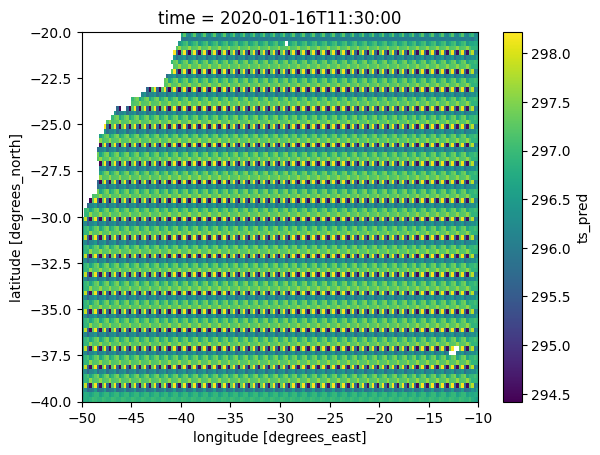

In [23]:
monthly_subset["ts_pred"].isel(time=0).plot()

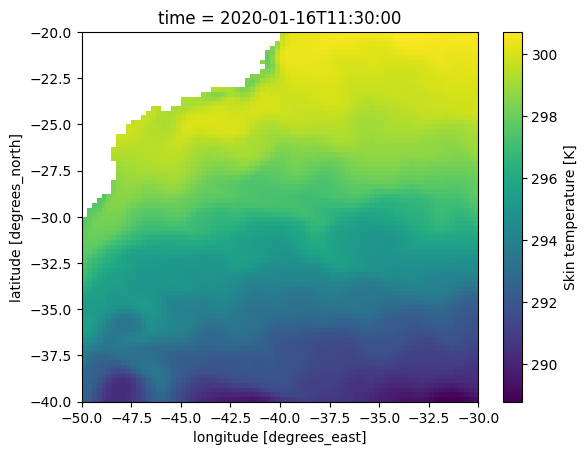

In [32]:
# original target
monthly_subset["ts"].where(~lsm_subset["lsm"].values).isel(time=0).plot()

In [ ]:
# Error
target = monthly_subset["ts"].where(~lsm_subset["lsm"].values)
err = target - monthly_subset["ts_pred"]

In [ ]:
err.isel(time=0).plot()

In [ ]:
err.isel(time=1).plot()